In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

22/04/06 10:26:14 WARN Utils: Your hostname, devkhk-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.30.1.27 instead (on interface en0)
22/04/06 10:26:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/06 10:26:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
trip_files = "/Users/devkhk/Documents/data-engineering-study/data/trips/*"
zone_file = "/Users/devkhk/Documents/data-engineering-study/data/taxi+_zone_lookup.csv"

In [4]:
trips_df = spark.read.csv(f"file:///{trip_files}", header=True, inferSchema=True)
zone_df = spark.read.csv(f"file:///{zone_file}", header=True, inferSchema=True)

In [5]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [6]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [7]:
# 두 테이블을 join해서 지역번호를 zone 이름으로 대체하는 테이블을 만든다.

query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM
    trips t
    LEFT JOIN 
        zone pz
    ON
        t.PULocationID = pz.LocationID 
    LEFT JOIN
        zone dz
    ON
        t.DOLocationID = dz.LocationID
"""


In [8]:
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

In [9]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [10]:
comb_df.select("pickup_date", "pickup_zone").show()

+-----------+--------------------+
|pickup_date|         pickup_zone|
+-----------+--------------------+
| 2021-03-01|                  NV|
| 2021-03-01|      Manhattanville|
| 2021-03-01|      Manhattanville|
| 2021-03-01|   LaGuardia Airport|
| 2021-03-01|        East Chelsea|
| 2021-03-01|Upper West Side S...|
| 2021-03-01|Penn Station/Madi...|
| 2021-03-01|         JFK Airport|
| 2021-03-01|   LaGuardia Airport|
| 2021-03-01|   LaGuardia Airport|
| 2021-03-01|         JFK Airport|
| 2021-03-01|     Lenox Hill East|
| 2021-03-01|Upper West Side S...|
| 2021-03-01|    Hamilton Heights|
| 2021-03-01|   East Harlem North|
| 2021-03-01|Upper West Side S...|
| 2021-03-01|         JFK Airport|
| 2021-03-01|Upper West Side S...|
| 2021-03-01|         JFK Airport|
| 2021-03-01|Sutton Place/Turt...|
+-----------+--------------------+
only showing top 20 rows



In [11]:
spark.sql("select pickup_date, pickup_time, pickup_zone, total_amount from comb").show()

+-----------+-----------+--------------------+------------+
|pickup_date|pickup_time|         pickup_zone|total_amount|
+-----------+-----------+--------------------+------------+
| 2021-03-01|          0|                  NV|         4.3|
| 2021-03-01|          0|      Manhattanville|         3.8|
| 2021-03-01|          0|      Manhattanville|         4.8|
| 2021-03-01|          0|   LaGuardia Airport|       70.07|
| 2021-03-01|          0|        East Chelsea|       11.16|
| 2021-03-01|          0|Upper West Side S...|       18.59|
| 2021-03-01|          0|Penn Station/Madi...|        43.8|
| 2021-03-01|          0|         JFK Airport|        32.3|
| 2021-03-01|          0|   LaGuardia Airport|       43.67|
| 2021-03-01|          0|   LaGuardia Airport|        46.1|
| 2021-03-01|          0|         JFK Airport|        45.3|
| 2021-03-01|          0|     Lenox Hill East|        19.3|
| 2021-03-01|          0|Upper West Side S...|        14.8|
| 2021-03-01|          0|    Hamilton He

In [12]:
spark.sql("select pickup_date, pickup_time, pickup_zone, total_amount from comb \
where pickup_time > 12").show()

+-----------+-----------+--------------------+------------+
|pickup_date|pickup_time|         pickup_zone|total_amount|
+-----------+-----------+--------------------+------------+
| 2021-02-28|         23|     Lenox Hill West|        9.36|
| 2021-02-28|         23|        Clinton East|        11.8|
| 2021-02-28|         23|Penn Station/Madi...|       17.16|
| 2021-02-28|         23|      Yorkville West|       17.88|
| 2021-02-28|         23|Penn Station/Madi...|        14.8|
| 2021-02-28|         23|        Clinton East|        14.3|
| 2021-02-28|         23|            Union Sq|        22.3|
| 2021-03-01|         22|         JFK Airport|        65.0|
| 2021-03-01|         13|   East Harlem South|         5.8|
| 2021-03-01|         13|         Murray Hill|         6.3|
| 2021-03-01|         13| UN/Turtle Bay South|        18.8|
| 2021-03-01|         13|    Manhattan Valley|         6.3|
| 2021-03-01|         13|            Union Sq|       12.36|
| 2021-03-01|         13|Upper East Side

In [13]:
spark.sql("select pickup_date, pickup_time, pickup_zone, total_amount from comb \
where pickup_date < '2020-12-31'").show() # 불필요한 데이터, 잘못된 데이터를 정리할 필요가 있다.

+-----------+-----------+--------------------+------------+
|pickup_date|pickup_time|         pickup_zone|total_amount|
+-----------+-----------+--------------------+------------+
| 2009-01-01|          0| Lincoln Square West|        21.3|
| 2008-12-31|         23|             Erasmus|         5.3|
| 2009-01-01|          0|        Clinton East|         9.3|
| 2009-01-01|          0|        Midtown East|        -3.3|
| 2009-01-01|          0|        Midtown East|         3.3|
| 2009-01-01|          0|Queensbridge/Rave...|         3.3|
| 2009-01-01|          0|         JFK Airport|        49.8|
| 2009-01-01|          1|Queensbridge/Rave...|         0.0|
| 2009-01-01|          0|Queensbridge/Rave...|         5.3|
| 2008-12-31|         23| Lincoln Square West|        13.0|
| 2008-12-31|         23|Sutton Place/Turt...|        9.96|
| 2008-12-31|         23|        Central Park|        12.8|
| 2008-12-31|         23|Upper East Side S...|         8.8|
| 2009-01-01|          0|      Yorkville

In [14]:
spark.sql("SELECT pickup_date, total_amount from comb").describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



In [15]:
spark.sql("SELECT passenger_count from comb").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [16]:
spark.sql("select trip_distance from comb").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [17]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [18]:
query = """
SELECT 
    DATE_TRUNC('month', c.pickup_date) as month,
    count(c.pickup_date) as count
FROM
    comb c
GROUP BY
    month
ORDER BY
    month desc
"""

In [19]:
spark.sql(query).show()

+-------------------+-------+
|              month|  count|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



In [31]:
# 불필요한 데이터가 무엇이 있는지 파악하기 위해 여러 칼럼들을 조회한 뒤 불필요한 데이들을 제거하기 위한 쿼리문을 짠다.

query = """
SELECT
    *
FROM
    comb
WHERE
    pickup_date >= '2021-01-01'
AND
    pickup_date < '2021-08-01'
AND
    trip_distance > 0
AND
    trip_distance < 600
AND
    passenger_count > 0
AND
    total_amount > 0
AND
    total_amount < 1000
    
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")


In [32]:
spark.sql("SELECT * FROM cleaned").show()

+---------+-----------+------------+-----------+------------+---------------+-------------+----------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|tip_amount|tolls_amount|total_amount|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+----------+------------+------------+--------------------+--------------------+
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|         1.13|      1.86|         0.0|       11.16|        East Chelsea|                  NV|
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|         2.68|      4.29|         0.0|       18.59|Upper West Side S...|      Yorkville East|
|        1| 2021-03-01|  2021-03-01|          0|           0|              1|         12.4|       0.0|         0.0|        43.8|Penn Station/Madi

In [33]:
spark.sql("SELECT trip_distance FROM cleaned").describe().show()

+-------+------------------+
|summary|     trip_distance|
+-------+------------------+
|  count|          13611856|
|   mean|2.8937482515242228|
| stddev|3.8929530471143825|
|    min|              0.01|
|    max|            599.88|
+-------+------------------+



In [34]:
query = """
SELECT 
    DATE_TRUNC('month', c.pickup_date) as month,
    count(c.pickup_date) as count
FROM
    cleaned c
GROUP BY
    month
ORDER BY
    month desc
"""

In [35]:
spark.sql(query).show()

+-------------------+-------+
|              month|  count|
+-------------------+-------+
|2021-07-01 00:00:00|2581825|
|2021-06-01 00:00:00|2603802|
|2021-05-01 00:00:00|2291075|
|2021-04-01 00:00:00|1963370|
|2021-03-01 00:00:00|1727251|
|2021-02-01 00:00:00|1224312|
|2021-01-01 00:00:00|1220221|
+-------------------+-------+



In [36]:
spark.sql("select passenger_count from cleaned").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          13611856|
|   mean| 1.461879188260587|
| stddev|1.0373327866056163|
|    min|                 1|
|    max|                 9|
+-------+------------------+



In [37]:
cleaned_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [38]:
spark.sql("SELECT total_amount from cleaned").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          13611856|
|   mean|18.004472735576808|
| stddev|12.913479072780651|
|    min|              0.01|
|    max|            988.35|
+-------+------------------+



In [41]:
# 어느정도 필터링된 df를 만든 뒤 시각화 하기

In [76]:
# 시각화에 필요한 모듈 import

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [48]:
cleaned_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [59]:
query = """
SELECT 
    pickup_date,
    count(*) as trips
FROM
    cleaned
GROUP BY
    pickup_date
ORDER BY
    pickup_date
"""

In [60]:
spark.sql(query).show()

+-----------+-----+
|pickup_date|trips|
+-----------+-----+
| 2021-01-01|21945|
| 2021-01-02|31158|
| 2021-01-03|23577|
| 2021-01-04|39151|
| 2021-01-05|41303|
| 2021-01-06|43778|
| 2021-01-07|44277|
| 2021-01-08|44461|
| 2021-01-09|36021|
| 2021-01-10|26940|
| 2021-01-11|41044|
| 2021-01-12|44138|
| 2021-01-13|45198|
| 2021-01-14|46874|
| 2021-01-15|46664|
| 2021-01-16|35051|
| 2021-01-17|29002|
| 2021-01-18|33216|
| 2021-01-19|45333|
| 2021-01-20|44187|
+-----------+-----+
only showing top 20 rows



In [61]:
# 원하는 데이터를 판다스로 전환
pd_df = spark.sql(query).toPandas() 

<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

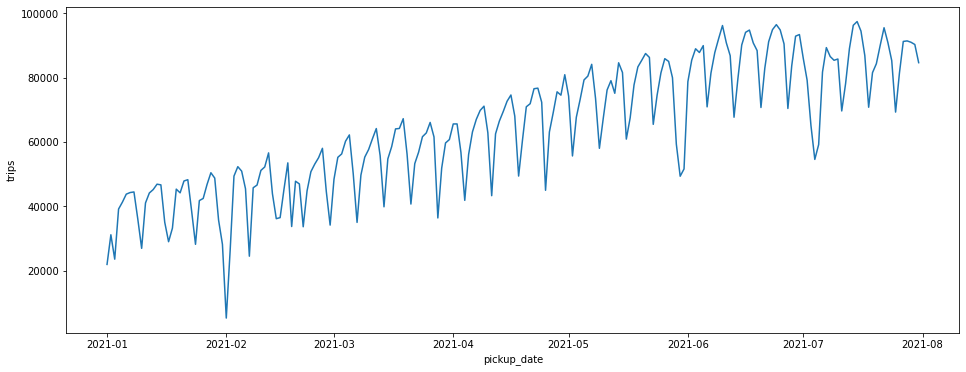

In [77]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x="pickup_date", y="trips", data=pd_df)

##### 

In [136]:
query = """
SELECT
    pickup_date,
    DATE_FORMAT(pickup_date, "EEEE") as day_of_week,
    count(*) as trips
FROM
    cleaned
GROUP BY
    pickup_date,
    day_of_week
"""

In [137]:
spark.sql(query).show()

+-----------+-----------+-----+
|pickup_date|day_of_week|trips|
+-----------+-----------+-----+
| 2021-03-24|  Wednesday|61624|
| 2021-03-03|  Wednesday|56274|
| 2021-03-05|     Friday|62184|
| 2021-03-09|    Tuesday|55279|
| 2021-03-26|     Friday|66060|
| 2021-03-01|     Monday|48407|
| 2021-03-19|     Friday|67224|
| 2021-03-13|   Saturday|55730|
| 2021-03-21|     Sunday|40703|
| 2021-02-28|     Sunday|34161|
| 2021-03-14|     Sunday|39845|
| 2021-03-08|     Monday|49697|
| 2021-04-14|  Wednesday|69446|
| 2021-03-23|    Tuesday|56823|
| 2021-03-02|    Tuesday|55226|
| 2021-05-27|   Thursday|85029|
| 2021-03-16|    Tuesday|58554|
| 2021-03-04|   Thursday|60221|
| 2021-03-25|   Thursday|62802|
| 2021-03-10|  Wednesday|57637|
+-----------+-----------+-----+
only showing top 20 rows



In [138]:
week_df = spark.sql(query).toPandas()

In [139]:
week_df

,pickup_date,day_of_week,trips
0,2021-03-24,Wednesday,61624
1,2021-03-03,Wednesday,56274
2,2021-03-05,Friday,62184
3,2021-03-09,Tuesday,55279
4,2021-03-26,Friday,66060
...,...,...,...
207,2021-03-30,Tuesday,59686
208,2021-04-24,Saturday,72330
209,2021-03-28,Sunday,36383
210,2021-04-25,Sunday,44980


In [152]:
data = week_df.groupby("day_of_week").trips.median()

In [156]:
data = data.to_frame().reset_index()

In [157]:
data

,day_of_week,trips
0,Friday,74590.0
1,Monday,57638.0
2,Saturday,62855.0
3,Sunday,44140.0
4,Thursday,73589.5
5,Tuesday,67820.0
6,Wednesday,70662.0


In [159]:
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday" : 0,
    "Monday" : 1,
    "Tuesday": 2,
    "Wednesday":3,
    "Thursday":4,
    "Friday":5,
    "Saturday":6
})

In [165]:
data.sort_values("sort_dow", inplace=True)

In [166]:
data

,day_of_week,trips,sort_dow
3,Sunday,44140.0,0
1,Monday,57638.0,1
5,Tuesday,67820.0,2
6,Wednesday,70662.0,3
4,Thursday,73589.5,4
0,Friday,74590.0,5
2,Saturday,62855.0,6


<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

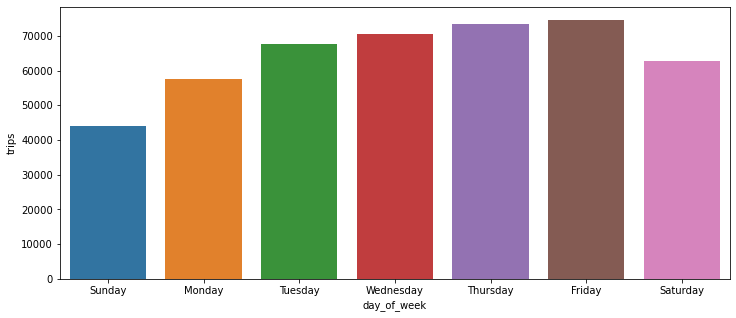

In [168]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x="day_of_week", y="trips", data=data)